<a href="https://colab.research.google.com/github/LakhiCharanMahato/Weather-Analysis-across-various-states-of-North-America/blob/master/New%20York/NY_note2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing Requirements

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"
import findspark
findspark.init()

# Library Requirements

**On the left hand side the storage icon is the local storage for Google colab.
Make a folder name lib there and upload all the items from Weather-Analysis-across-various-states-of-North-America/New York/lib/**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Initial Visualization

  * *TMIN* Minimal Temperature during the day.
  * *TMAX* Maximal Temperature During the day.
  * *TOBS* "Observed" temperature. Exact meaning not clear, but is less noisy than *TMIN* and *TMAX*
  * *PRCP* Total percipitation during the day.
  * *SNOW* Amount of snow that fell during the day.
  * *SNWD* Snow Depth
  * *TMIN_s20*, *TMAX_s20*,... A smoothed version of the six raw measurements.

In [3]:
import os
os.environ["PYSPARK_PYTHON"]="python3"
os.environ["PYSPARK_DRIVER_PYTHON"] = "python3"

import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStatistics.py'])

from pyspark import SparkContext
from pyspark.sql import *
import pyspark.sql
sqlContext = SQLContext(sc)

import numpy as np
from lib.numpy_pack import packArray,unpackArray
from lib.spark_PCA import computeCov
from lib.computeStatistics import *

Populating the interactive namespace from numpy and matplotlib


In [0]:
import warnings  # Suppress Warnings
warnings.filterwarnings('ignore')

_figsize=(10,7)

In [5]:
state='NY'
data_dir='../Data/Weather'

tarname=state+'.tgz'
parquet=state+'.parquet'

%mkdir -p $data_dir
!rm -rf $data_dir/$tarname

command="curl https://mas-dse-open.s3.amazonaws.com/Weather/by_state/%s > %s/%s"%(tarname,data_dir,tarname)
print(command)
!$command
!ls -lh $data_dir/$tarname

curl https://mas-dse-open.s3.amazonaws.com/Weather/by_state/NY.tgz > ../Data/Weather/NY.tgz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 63.2M  100 63.2M    0     0  23.4M      0  0:00:02  0:00:02 --:--:-- 23.4M
-rw-r--r-- 1 root root 64M Mar 27 05:55 ../Data/Weather/NY.tgz


In [6]:
!ls $data_dir

NY.parquet  NY.tgz  stations.parquet  STAT_NY.pickle  Weather_Stations.tgz


In [7]:
cur_dir,=!pwd
%cd $data_dir
!tar -xzf $tarname
!du ./$parquet
%cd $cur_dir

/Data/Weather
77828	./NY.parquet
/content


In [8]:
!du -h $data_dir/$parquet

77M	../Data/Weather/NY.parquet


In [9]:
print(parquet)
weather_df=sqlContext.read.parquet(data_dir+'/'+parquet)
weather_df=weather_df.drop('State') # we drop State because it already exists in "Stations".

NY.parquet


In [10]:
%%time
weather_df.count()

CPU times: user 2.31 ms, sys: 50 µs, total: 2.36 ms
Wall time: 2.07 s


168398

In [11]:
print('number of rows=',weather_df.cache().count())
weather_df.show(5)

number of rows= 168398
+-----------+-----------+----+--------------------+-----------------+--------------+------------------+-----------------+-----------------+
|    Station|Measurement|Year|              Values|       dist_coast|      latitude|         longitude|        elevation|             name|
+-----------+-----------+----+--------------------+-----------------+--------------+------------------+-----------------+-----------------+
|USW00094704|   PRCP_s20|1945|[00 00 00 00 00 0...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|DANSVILLE MUNI AP|
|USW00094704|   PRCP_s20|1946|[99 46 52 46 0B 4...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|DANSVILLE MUNI AP|
|USW00094704|   PRCP_s20|1947|[79 4C 75 4C 8F 4...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|DANSVILLE MUNI AP|
|USW00094704|   PRCP_s20|1948|[72 48 7A 48 85 4...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|DANSVILLE MUNI A

In [12]:
#read statistics
filename='STAT_%s.pickle'%state
command="curl https://mas-dse-open.s3.amazonaws.com/Weather/by_state_2/%s.gz > %s/%s.gz"%(filename,data_dir,filename)
print(command)
!$command

curl https://mas-dse-open.s3.amazonaws.com/Weather/by_state_2/STAT_NY.pickle.gz > ../Data/Weather/STAT_NY.pickle.gz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 29.9M  100 29.9M    0     0  16.4M      0  0:00:01  0:00:01 --:--:-- 16.4M


In [13]:
gzpath='%s/%s.gz'%(data_dir,filename)
print(gzpath)
!ls -l $gzpath
!gunzip -f $gzpath

../Data/Weather/STAT_NY.pickle.gz
-rw-r--r-- 1 root root 31373293 Mar 27 05:56 ../Data/Weather/STAT_NY.pickle.gz


In [14]:
STAT,STAT_Descriptions = load(open(data_dir+'/'+filename,'rb'),allow_pickle=True)
print('keys from STAT=',STAT.keys())

keys from STAT= dict_keys(['SNOW_s20', 'TMIN_s20', 'TOBS', 'SNWD_s20', 'PRCP_s20', 'TOBS_s20', 'PRCP', 'TMAX', 'TMAX_s20', 'TMIN', 'SNOW', 'SNWD'])


In [15]:
print("   Name  \t                 Description             \t  Size")
print("-"*80)
print('\n'.join(["%10s\t%40s\t%s"%(s[0],s[1],str(s[2])) for s in STAT_Descriptions]))

   Name  	                 Description             	  Size
--------------------------------------------------------------------------------
SortedVals	                        Sample of values	vector whose length varies between measurements
     UnDef	      sample of number of undefs per row	vector whose length varies between measurements
      mean	                              mean value	()
       std	                                     std	()
    low100	                               bottom 1%	()
   high100	                                  top 1%	()
   low1000	                             bottom 0.1%	()
  high1000	                                top 0.1%	()
         E	                   Sum of values per day	(365,)
        NE	                 count of values per day	(365,)
      Mean	                                    E/NE	(365,)
         O	                   Sum of outer products	(365, 365)
        NO	               counts for outer products	(365, 365)
       Cov	                

In [16]:
filename='Weather_Stations.tgz'
parquet='stations.parquet'
command="curl https://mas-dse-open.s3.amazonaws.com/Weather/%s > %s/%s"%(filename,data_dir,filename)
print(command)
!$command

curl https://mas-dse-open.s3.amazonaws.com/Weather/Weather_Stations.tgz > ../Data/Weather/Weather_Stations.tgz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  344k  100  344k    0     0   439k      0 --:--:-- --:--:-- --:--:--  439k


In [17]:
%cd $data_dir
!tar -xzf $filename
!du -s *.parquet
%cd $cur_dir

/Data/Weather
77828	NY.parquet
420	stations.parquet
/content


In [18]:
stations_df =sqlContext.read.parquet(data_dir+'/'+parquet)
stations_df.show(5)

+-----------+----------+--------+---------+---------+-----+----------------+
|    Station|Dist_coast|Latitude|Longitude|Elevation|State|            Name|
+-----------+----------+--------+---------+---------+-----+----------------+
|USC00341900|   739.956|    36.3| -96.4667|    242.3|   OK|       CLEVELAND|
|USC00428114|    908.22|    40.1|-111.6667|   1409.1|   UT|SPANISH FORK 1 S|
|USC00165926|   23.8801| 29.7853| -90.1158|      0.9|   LA|   MARRERO 9 SSW|
|USC00411974|   541.905| 31.5333|-101.2842|    755.9|   TX|        COPE RCH|
|USC00318906|   310.311| 35.5231| -81.4439|    274.3|   NC|    VALE AG 2 SW|
+-----------+----------+--------+---------+---------+-----+----------------+
only showing top 5 rows



In [19]:
weather_df=weather_df#.drop('name').drop('dist_coast')
weather_df.show(3)

+-----------+-----------+----+--------------------+-----------------+--------------+------------------+-----------------+-----------------+
|    Station|Measurement|Year|              Values|       dist_coast|      latitude|         longitude|        elevation|             name|
+-----------+-----------+----+--------------------+-----------------+--------------+------------------+-----------------+-----------------+
|USW00094704|   PRCP_s20|1945|[00 00 00 00 00 0...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|DANSVILLE MUNI AP|
|USW00094704|   PRCP_s20|1946|[99 46 52 46 0B 4...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|DANSVILLE MUNI AP|
|USW00094704|   PRCP_s20|1947|[79 4C 75 4C 8F 4...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|DANSVILLE MUNI AP|
+-----------+-----------+----+--------------------+-----------------+--------------+------------------+-----------------+-----------------+
only showing top 3 r

In [20]:
jdf=weather_df.join(stations_df,on='Station',how='left')
jdf.show(3)
jdf.columns

+-----------+-----------+----+--------------------+-----------------+--------------+------------------+-----------------+-----------------+----------+--------+---------+---------+-----+-----------------+
|    Station|Measurement|Year|              Values|       dist_coast|      latitude|         longitude|        elevation|             name|Dist_coast|Latitude|Longitude|Elevation|State|             Name|
+-----------+-----------+----+--------------------+-----------------+--------------+------------------+-----------------+-----------------+----------+--------+---------+---------+-----+-----------------+
|USW00094704|   PRCP_s20|1945|[00 00 00 00 00 0...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|DANSVILLE MUNI AP|   361.832| 42.5708| -77.7133|    208.8|   NY|DANSVILLE MUNI AP|
|USW00094704|   PRCP_s20|1946|[99 46 52 46 0B 4...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|DANSVILLE MUNI AP|   361.832| 42.5708| -77.7133|    208.8|   NY

['Station',
 'Measurement',
 'Year',
 'Values',
 'dist_coast',
 'latitude',
 'longitude',
 'elevation',
 'name',
 'Dist_coast',
 'Latitude',
 'Longitude',
 'Elevation',
 'State',
 'Name']

In [21]:
sqlContext.registerDataFrameAsTable(weather_df,'jdf')

#find the stations in NY with the most measurements.
sqlContext.sql('select name,count(name) as count from jdf group by name order by count desc').show(5)
#GROUP BY name ORDER BY count').show(5)

+--------------------+-----+
|                name|count|
+--------------------+-----+
|     SETAUKET STRONG| 1438|
|NEW YORK CNTRL PK...| 1430|
|            LOWVILLE| 1410|
|              ELMIRA| 1408|
|            ANGELICA| 1406|
+--------------------+-----+
only showing top 5 rows



In [22]:
#find how many measurements of each type for a particlar station
stat='ELMIRA'
Query="""
SELECT Measurement,count(Measurement) as count 
FROM jdf 
WHERE Name='%s' 
GROUP BY Measurement
"""%stat
sqlContext.sql(Query).show()

+-----------+-----+
|Measurement|count|
+-----------+-----+
|   TMIN_s20|  120|
|       TMIN|  120|
|   SNOW_s20|  121|
|       TOBS|  113|
|   SNWD_s20|  109|
|   TOBS_s20|  113|
|   PRCP_s20|  121|
|       TMAX|  120|
|       SNOW|  121|
|   TMAX_s20|  120|
|       SNWD|  109|
|       PRCP|  121|
+-----------+-----+



In [24]:
#find year with all 12 measurements
Query="""
SELECT Year,count(Year) as count 
FROM jdf 
WHERE Name='%s' 
GROUP BY Year
ORDER BY count DESC
"""%stat
sqlContext.sql(Query).show(5)

+----+-----+
|Year|count|
+----+-----+
|1950|   12|
|1919|   12|
|1936|   12|
|1951|   12|
|1921|   12|
+----+-----+
only showing top 5 rows



In [25]:
# get all measurements for a particular year and a particular station
year=2007
Query="""
SELECT *
FROM jdf 
WHERE Name='%s' 
and Year=%d
"""%(stat,year )
pandas_df=sqlContext.sql(Query).toPandas()
pandas_df=pandas_df.set_index('Measurement')
pandas_df

,Station,Year,Values,dist_coast,latitude,longitude,elevation,name
Measurement,,,,,,,,
SNOW_s20,USC00302610,2007,"[102, 61, 227, 61, 128, 62, 17, 63, 170, 63, 7...",272.682007,42.099701,-76.8358,288.600006,ELMIRA
SNWD_s20,USC00302610,2007,"[170, 70, 121, 71, 48, 72, 170, 72, 45, 73, 19...",272.682007,42.099701,-76.8358,288.600006,ELMIRA
TOBS_s20,USC00302610,2007,"[85, 203, 22, 204, 135, 204, 255, 204, 123, 20...",272.682007,42.099701,-76.8358,288.600006,ELMIRA
PRCP_s20,USC00302610,2007,"[25, 76, 17, 76, 25, 76, 30, 76, 36, 76, 43, 7...",272.682007,42.099701,-76.8358,288.600006,ELMIRA
TMAX_s20,USC00302610,2007,"[79, 82, 17, 82, 214, 81, 149, 81, 83, 81, 15,...",272.682007,42.099701,-76.8358,288.600006,ELMIRA
TMIN_s20,USC00302610,2007,"[85, 209, 139, 209, 195, 209, 253, 209, 59, 21...",272.682007,42.099701,-76.8358,288.600006,ELMIRA
PRCP,USC00302610,2007,"[0, 69, 0, 0, 0, 0, 0, 72, 128, 86, 0, 66, 112...",272.682007,42.099701,-76.8358,288.600006,ELMIRA
SNOW,USC00302610,2007,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",272.682007,42.099701,-76.8358,288.600006,ELMIRA
SNWD,USC00302610,2007,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",272.682007,42.099701,-76.8358,288.600006,ELMIRA


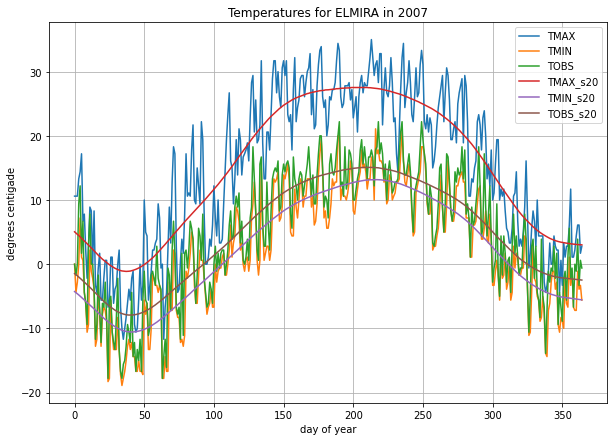

In [26]:
_tmax_20=unpackArray(pandas_df.loc['TMAX_s20','Values'],np.float16)/10.
_tmin_20=unpackArray(pandas_df.loc['TMIN_s20','Values'],np.float16)/10.
_tobs_20=unpackArray(pandas_df.loc['TOBS_s20','Values'],np.float16)/10.
_tmax=unpackArray(pandas_df.loc['TMAX','Values'],np.float16)/10.
_tmin=unpackArray(pandas_df.loc['TMIN','Values'],np.float16)/10.
_tobs=unpackArray(pandas_df.loc['TOBS','Values'],np.float16)/10.
figure(figsize=_figsize)
plot(_tmax,label='TMAX');
plot(_tmin,label='TMIN');
plot(_tobs,label='TOBS');

plot(_tmax_20,label='TMAX_s20');
plot(_tmin_20,label='TMIN_s20');
plot(_tobs_20,label='TOBS_s20');
xlabel('day of year')
ylabel('degrees centigade')
title('Temperatures for %s in %d'%(stat,year))
legend()
grid()

**Word from author:**
TOBS is the temperature measured at noon.

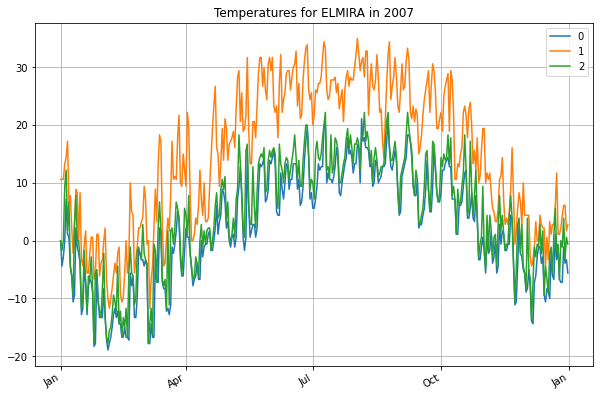

In [27]:
from lib.YearPlotter import YearPlotter
T=np.stack([_tmin,_tmax,_tobs])

fig, ax = plt.subplots(figsize=_figsize);
YP=YearPlotter()
YP.plot(T.transpose(),fig,ax,title='Temperatures for %s in %d'%(stat,year));
plt.savefig('percipitation.png')
#title('A sample of graphs');

In [0]:
from lib.MultiPlot import *
YP=YearPlotter()
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m,label=m)
    

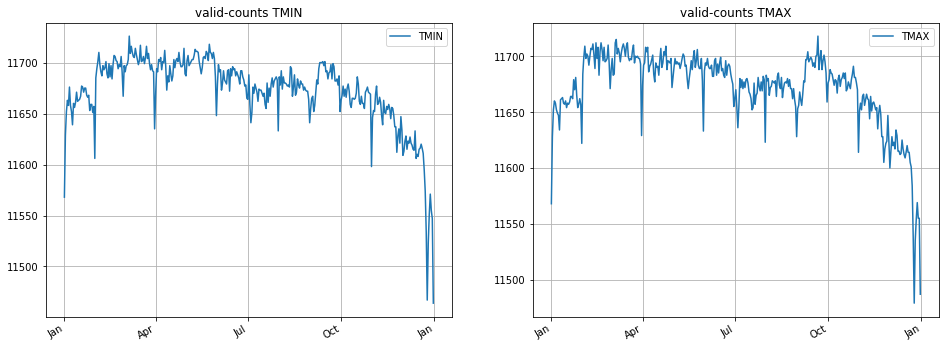

In [29]:
plot_pair(['TMIN','TMAX'],plot_valid)

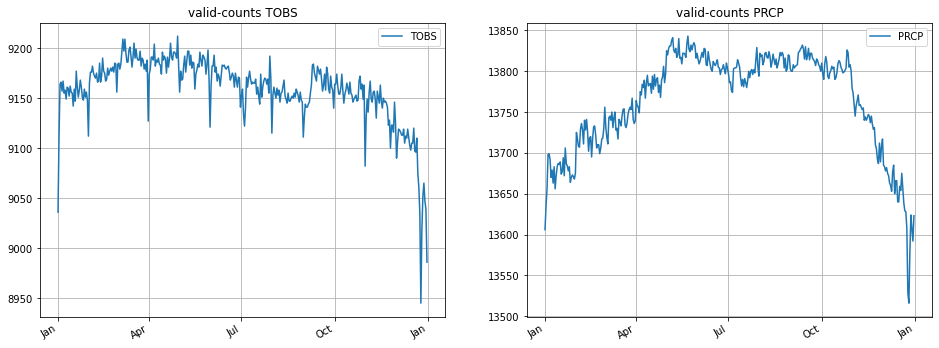

In [30]:
plot_pair(['TOBS','PRCP'],plot_valid)

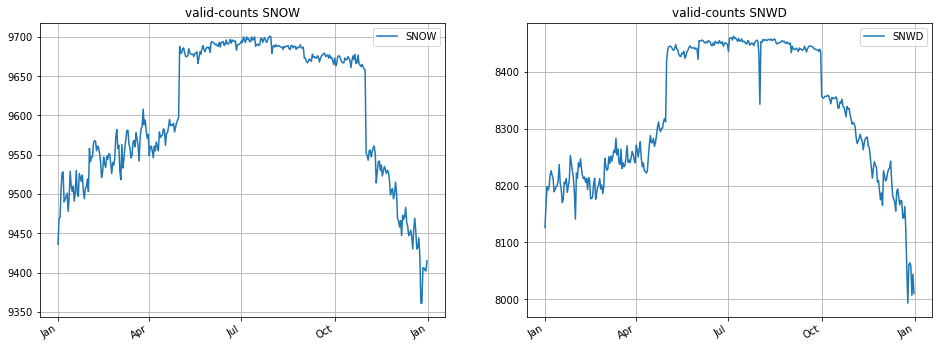

In [31]:
# Note that for "SNOW" there are more missing measurements in the summer
# While for SNWD there are less missing in the summer
plot_pair(['SNOW', 'SNWD'],plot_valid)

**Word from Author:** Values from May to November are manmade hence the above graph.

In [0]:
def plot_mean_std(m,fig,axis):
    scale=1.
    temps=['TMIN','TMAX','TOBS','TMIN_s20','TMAX_s20','TOBS_s20']
    percipitation=['PRCP','SNOW','SNWD','PRCP_s20','SNOW_s20','SNWD_s20']
    _labels=['mean+std','mean','mean-std']
    if (m in temps or m=='PRCP'):
        scale=10.
    mean=STAT[m]['Mean']/scale
    std=np.sqrt(STAT[m]['Var'])/scale
    graphs=np.vstack([mean+std,mean,mean-std]).transpose()
    YP.plot(graphs,fig,axis,labels=_labels,title='Mean+-std   '+m)
    if (m in temps):
        axis.set_ylabel('Degrees Celsius')
    if (m in percipitation):
        axis.set_ylabel('millimeter')



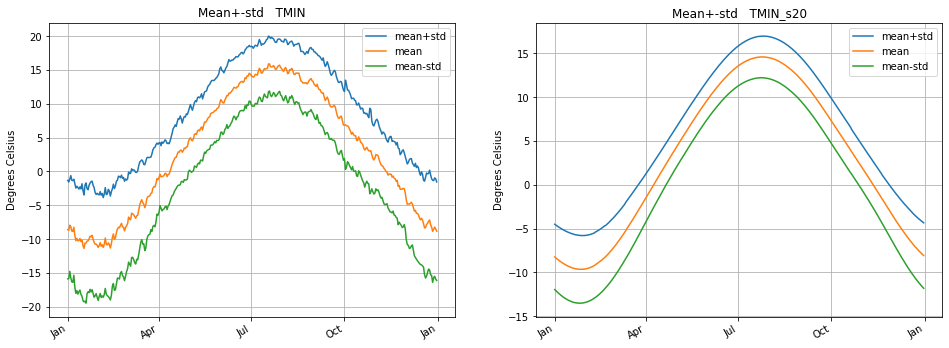

In [33]:
plot_pair(['TMIN','TMIN_s20'],plot_mean_std)

**Word from Author:** We see a greater deviation in TMIN during the months of Jan to April in the above plot.

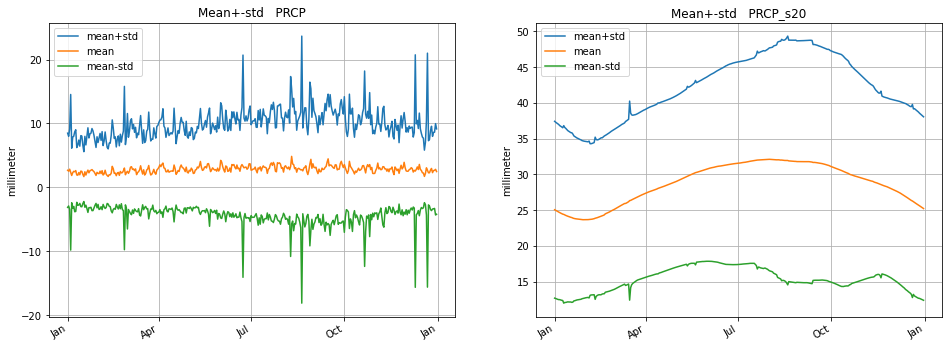

In [34]:
plot_pair(['PRCP','PRCP_s20'],plot_mean_std)

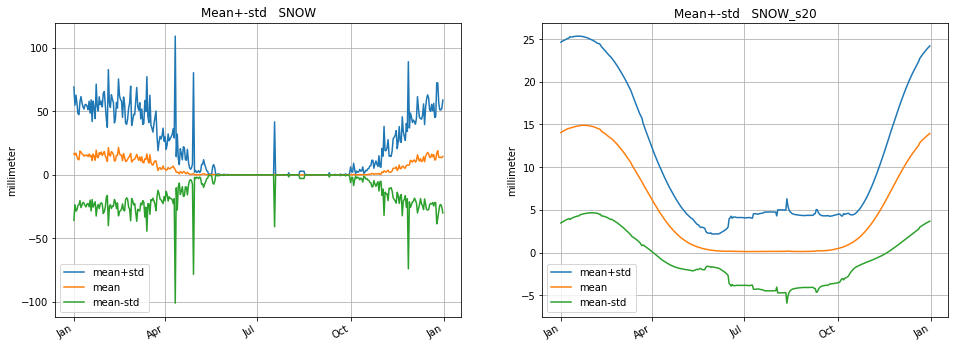

In [35]:
plot_pair(['SNOW', 'SNOW_s20'],plot_mean_std)

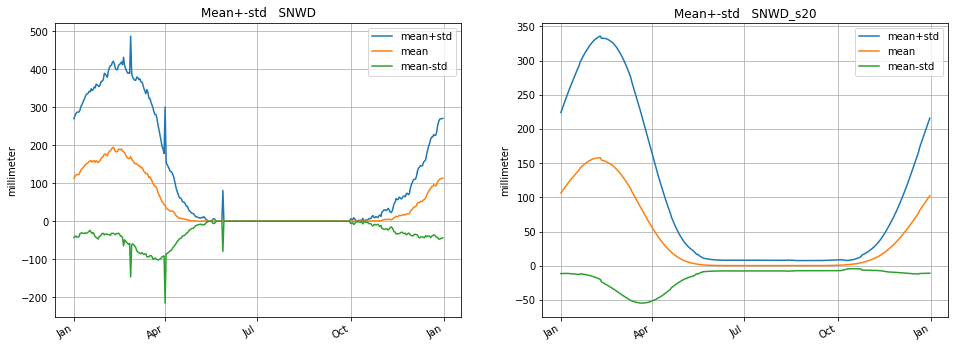

In [36]:
plot_pair(['SNWD', 'SNWD_s20'],plot_mean_std)

**Word from Author:** Snow Depth is a smoother graph as compared to Snowfall because snow depth does not change so rapidly and hence the plots of SNWD and SNOW.

# Eigen Vector Plots

In [0]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    L=([0,]+list(cumsum(EV[:k])))/sum(EV)
    #print m,L
    plot(L)
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()

In [0]:
# create a subdirectory in which to place the plots.
!mkdir r_figures

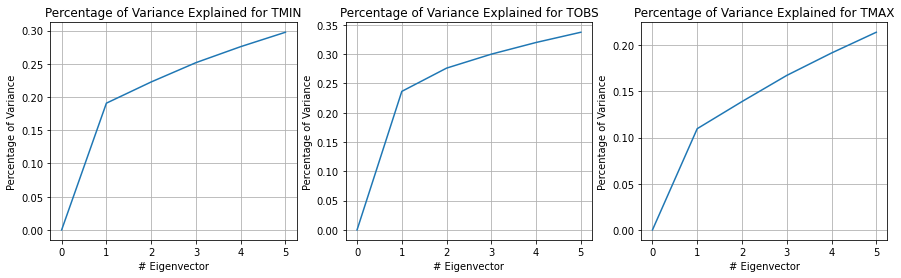

In [39]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1

**Word from Author:** TOBS is less noisy as compared to TMIN and TMAX and so its top 5 eigen vectors explain about 35% of Variance.

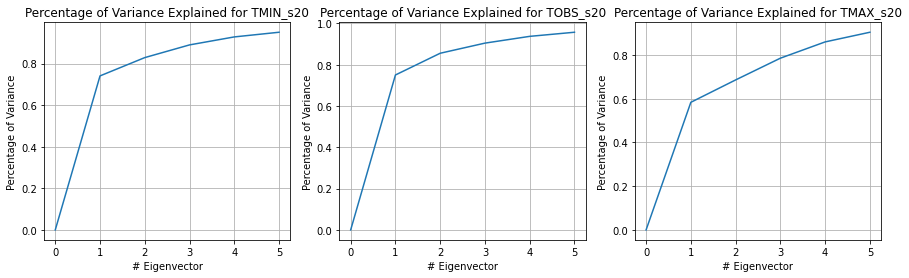

In [40]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN_s20', 'TOBS_s20', 'TMAX_s20']: 
    pltVarExplained(j)
    j+=1

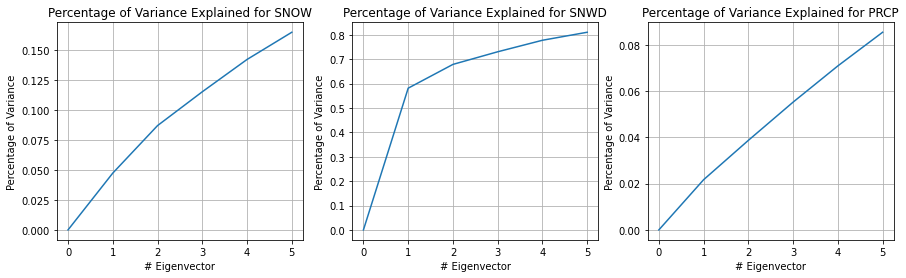

In [42]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 

**Word from the Author:** Comparing the above 3 graphs we see that for SNOW the top 5 eigen vectors explain about 16%, PRCP explains about 8% and for SNWD it explains about 80%. By far SNWD this is the most explained by top 5 eigen vectors and hence we can build a pretty good low dimensional plot of SNWD.

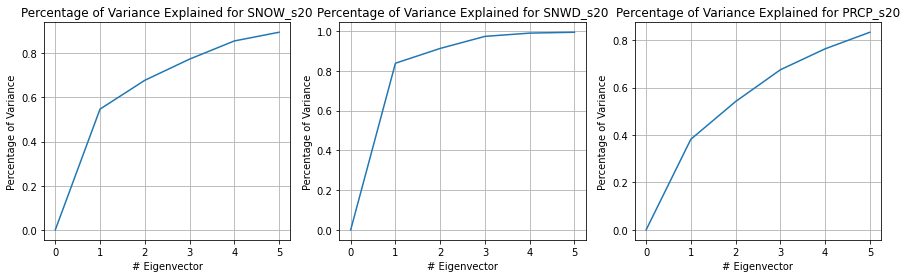

In [43]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW_s20', 'SNWD_s20', 'PRCP_s20']:
    pltVarExplained(j)
    j+=1 

# Plotting top 3 eigen vectors

In [0]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

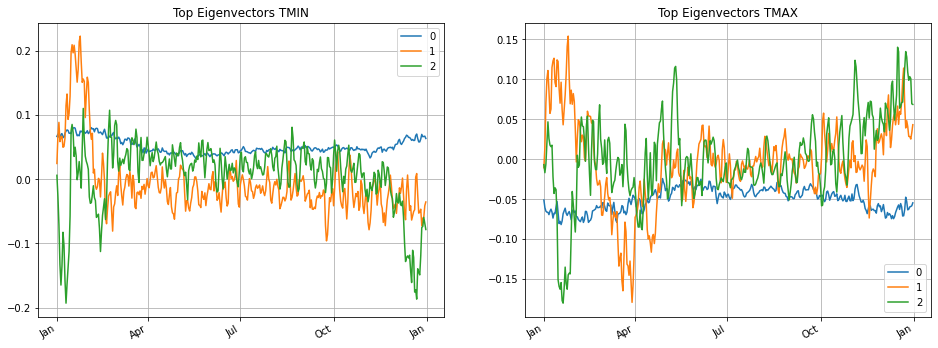

In [45]:
plot_pair(['TMIN','TMAX'],plot_eigen)

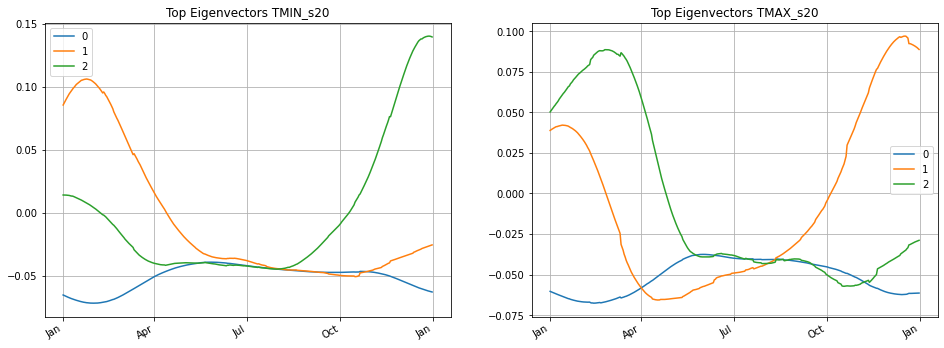

In [46]:
plot_pair(['TMIN_s20','TMAX_s20'],plot_eigen)

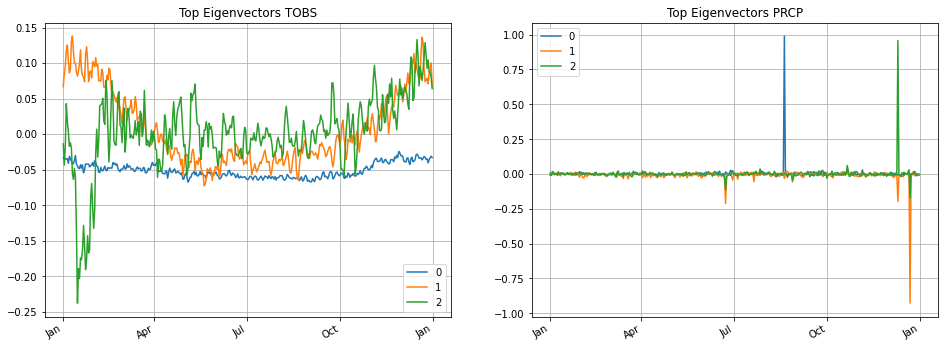

In [47]:
plot_pair(['TOBS','PRCP'],plot_eigen)

**Word from the Author:** For the plot of TOBS we see that the zeroth eigen vector is mostly a negative constant throughout the year. It basically explains the mean temperature. The 1.st eigen vector is basically high in the winters and low in the summers. It even crosses the zero. It basically explains how much summer and winter are different from each other.

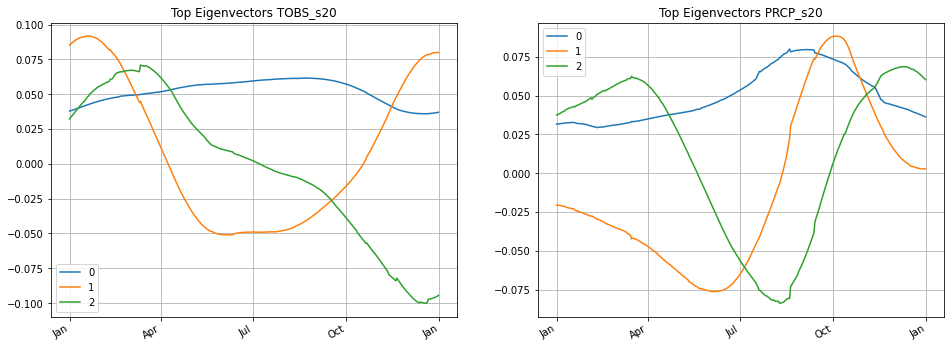

In [48]:
plot_pair(['TOBS_s20','PRCP_s20'],plot_eigen)

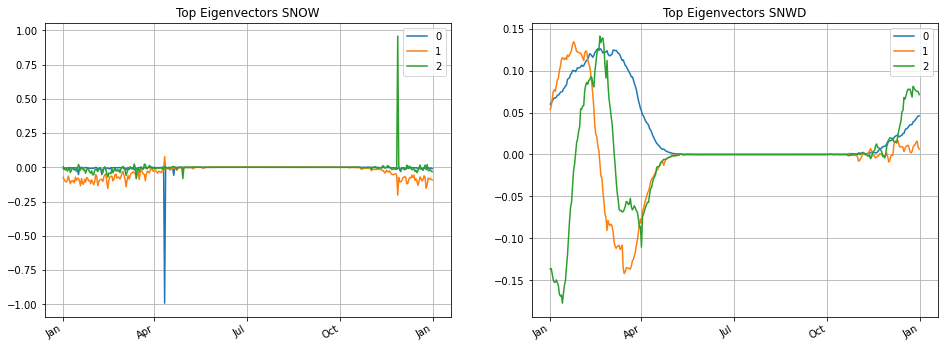

In [49]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

**Word from the Author:** For the plot of SNWD the zeroth eigen vector very much looks like the overal snow. The 1.st explains whether the snow is early or late. The 2.nd one explains whether the season is season is short or long.

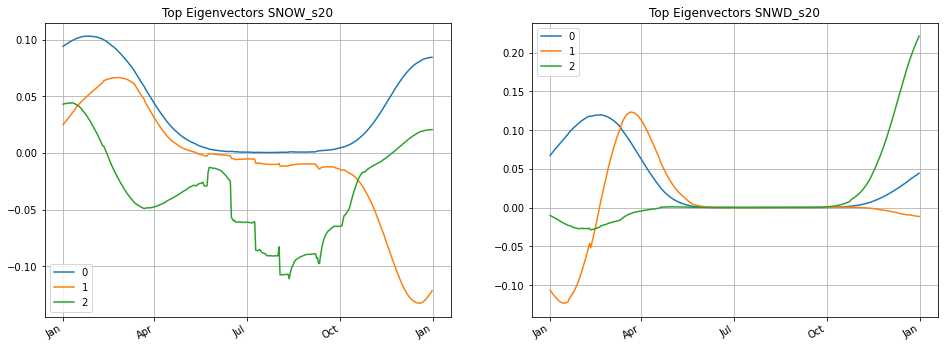

In [51]:
plot_pair(['SNOW_s20', 'SNWD_s20'],plot_eigen)